# Métricas UAJ - Proyecto Final

En este cuaderno hacemos un despliegue detallado de las métricas que consideramos de interés para el proyecto.

A pesar de que "ingame" se muestran los mapas de calor del recorrido de los bots y el atasco de los mismos, también creemos el que el análisis en bruto de esos datos y la muestra de gráficos y tablas representativas de los mismos era un aporte necesario.

Índice:

- 1. Configuración inicial.
- 2. Lectura y unificación.
- 3. Preprocesado y limpieza.
- 4. Cálculo de métricas por sesión y nivel
- 5. Visualización de metricas
- 6. Conclusiones derivadas de las métricas


## 1. Configuración inicial

En este apartado importamos las librerías necesarias y definimos rutas y parámetros globales que usaremos en todo el notebook.


In [18]:

import os
import glob
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytz

# rutas
DATA_DIR   = './data'       # JSONs a analizar (no carpetas)
OUTPUT_DIR = './output'     # (opvional) CSVs, PNGs
os.makedirs(OUTPUT_DIR, exist_ok=True)

# para el timestamp
MADRID = pytz.timezone('Europe/Madrid')

# params
CELL_SIZE   = 1.0           # tam celdas
TOTAL_CELLS = 1000          


## 2. Lectura y unificación 

Leemos todos los archivos '*.json' de la carpeta '/data' que es donde se vuelcan los resultados de cada sesión (en la misma hay otras subcarpetas con jsons de prueba y otras prácticas que no se tienen en cuenta) y los unificamos en un único DataFrame.
Mostramos así mismo un pequeño resumen de los archivos que hemos encontrado y unificado así como los eventos de Position, LevelEnd, LevelStart, GameStart y GameEnd que hemos rastreado dentro para confirmar que tenemos los archivos que esperamos y que dentro de ellos, los eventos esenciales de comienzo y finalización están presentes, asegurando que la lectura ha sido correcta.

In [19]:
# 2. unifica los json en un dataframe comun
json_files = glob.glob(os.path.join(DATA_DIR, '*.json'))
print(f"Found {len(json_files)} files")

dfs = []
for fp in json_files:
    with open(fp, 'r', encoding='utf-8') as f:
        data = json.load(f)
    dfs.append(pd.DataFrame(data))

df = pd.concat(dfs, ignore_index=True)
print("Total events:", len(df))
print("Unique sessions:", df['sessionID'].nunique())
print("Event types:\n", df['eventType'].value_counts())
df.head()


Found 10 files
Total events: 679549
Unique sessions: 10
Event types:
 eventType
Position      679489
LevelEnd          20
LevelStart        20
GameStart         10
GameEnd           10
Name: count, dtype: int64


,eventType,gameID,playerID,sessionID,timestamp,levelStarted,isStuck,posX,posY,posZ
0,GameStart,Damn,200468402800683,2004684028006831747474244411,1747474244411,NaN,NaN,NaN,NaN,NaN
1,LevelStart,Damn,200468402800683,2004684028006831747474244411,1747474244411,0.0,NaN,NaN,NaN,NaN
2,Position,Damn,200468402800683,2004684028006831747474244411,1747474244411,NaN,False,0.813311,4.172843,5.16052
3,Position,Damn,200468402800683,2004684028006831747474244411,1747474244411,NaN,False,0.813311,4.172843,5.16052
4,Position,Damn,200468402800683,2004684028006831747474244411,1747474244411,NaN,False,0.813311,4.172843,5.16052


## 3. Preprocesado y limpieza

En este apartado se hace la transformación a tabla de los datos unificados del dataframe. 

Los timestamps los convertimos a fecha y hora local para constatar cuando fueron creados los archivos, extraemos la sesión de cada nivel y le damos un numero representativo, así como el nivel al que corresponde dicha sesión para que se pueda tener referencia del mismo y sea más fácil ver a cual pertenecen los datos obtenidos.

Por últimos filtramos las posiciones totales de cada sesión y creamos un grid con todas ellas por cada nivel, de tamaño 1x1 como estuviera dentro del nivel jugable que luego nos servirá para dar pie a las métricas de superficie cubierta y atascos en ella.

In [ ]:
# 3.1) timestampa -> fecha y hora en Madrid

df['dt_utc'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True)
df['dt']     = df['dt_utc'].dt.tz_convert(MADRID).dt.tz_localize(None)

# 3.2) session_idx  (1,2,3…) [notamental-> si falla algo es SESSION no SESION]
df['session_idx'] = df['sessionID'].astype('category').cat.codes + 1

# 3.3) level_idx por session
level_map = (
    df[df['eventType']=='LevelStart']
      .groupby('session_idx')['levelStarted']
      .first()
      .astype(int)
      .rename('level_idx')
      .reset_index()
)

# 3.4) filtra solo las posiciones de cada sesion
df_pos = (
    df[df['eventType']=='Position']
      .merge(level_map, on='session_idx', how='left')
      .copy()
)

# 3.5) crea grid con las posiciones para luego poder usarlo 
df_pos['grid_x'] = np.floor(df_pos['posX'] / CELL_SIZE).astype(int) #cell size en 1.0
df_pos['grid_z'] = np.floor(df_pos['posZ'] / CELL_SIZE).astype(int)

# 3.6) Tabla de sesion-nivel correspondiente
summary = (
    df_pos
      .groupby(['session_idx','level_idx'])
      .agg(
          total_positions = ('eventType','size'),
          start_time      = ('dt','min'),
      )
      .reset_index()
)

print("Summary of positions per session & level:")
display(summary)


Summary of positions per session & level:


,session_idx,level_idx,total_positions,start_time
0,1,0,70779,2025-05-17 11:30:44.411
1,2,1,70870,2025-05-17 11:49:14.667
2,3,3,70882,2025-05-17 12:08:28.867
3,4,4,56195,2025-05-17 12:18:55.336
4,5,2,70793,2025-05-17 12:50:41.717
5,6,0,70830,2025-05-17 13:02:55.653
6,7,1,70990,2025-05-17 13:13:22.282
7,8,2,70996,2025-05-17 13:23:58.549
8,9,3,71005,2025-05-17 13:34:27.088
9,10,4,56149,2025-05-17 13:45:59.285


## 4. Cálculo de métricas por sesión y nivel

Se usa BFS para hacer el cálculo de casillas de superficie accesibles en cada nivel, partiendo del spawn point y luego cada casilla contigua a esta que un bot pise pasa a incorporarse como "casilla accesible" de ese nivel, de esta manera, con la suposición de que con varias pruebas algún bot "pisó" una casilla se mapean todas las que fueron pisadas y se supone que entre todos ellos, a lo largo de todas las sesiones todas las posibles fueron "pisadas" y por ello eran accesibles lo que nos da el total disponible por nivel (reachable_cells).

Luego en cada una de las sesiones se cuentan cuantas de ellas se pisaron(visited_cells) y por ende cuanta superficie se cubrió en esa sesión en particular. de esta manera las celdas de las zonas inaccesibles no entran en el cómputo de superficie disponible, lo que nos permite lanzar un mapa de calor a nivel de gráfico estadístico más adelante y abordar la superficie cubierta por sesión.

También calculamos la distancia total recorrida por los bots en conjunto por cada sesión-nivel para determinar si los niveles que son más amplios o tienen más distancia recorrible por tramo influyen a la hora de cuantos "stucks" por unidad de distancia pueda haber (véase apartado 5.2).

Por último ofrecemos dos ratios relacionados con los datos anteriores; "stuck_ratio": para medir la cantidad de atascos registrados frente al total de posiciones alcanzadas y "coverage_ratio": para medir la cantidad de celdas visitadas por sesión frente al total disponible.

In [21]:
from collections import deque

# 4.0) Celdas alcanzables en cada nivel (empirical BFS)
level_cells = (
    df_pos
    .groupby('level_idx')[['grid_x','grid_z']]
    .apply(lambda g: set(zip(g['grid_x'], g['grid_z'])))
    .rename('cells_set')
    .reset_index()
)

reachable_list = []
for _, row in level_cells.iterrows():
    lvl   = row['level_idx']
    cells = row['cells_set']

    # semilla= spawn
    seeds = (
      df_pos[df_pos['level_idx']==lvl]
        .sort_values('timestamp')
        .groupby('session_idx')
        .first()[['grid_x','grid_z']]
        .apply(lambda x: (int(x['grid_x']),int(x['grid_z'])), axis=1)
        .tolist()
    )
    seeds = set(seeds)

    visited = set(seeds)
    queue   = deque(seeds)
    while queue:
        x,z = queue.popleft()
        for dx,dz in [(1,0),(-1,0),(0,1),(0,-1)]:
            n = (x+dx,z+dz)
            if n in cells and n not in visited:
                visited.add(n)
                queue.append(n)

    reachable_list.append({
        'level_idx': lvl,
        'reachable_cells': len(visited)
    })

df_reachable = pd.DataFrame(reachable_list)
print("Celdas alcanzables por nivel:")
display(df_reachable)


# 4.1) Para metricas de distancia recorrida por los bots (sumamos distancias Euclideas de una pos a la siguiente para cada bot)
shifted = df_pos.groupby(['session_idx','level_idx'])[['posX','posY','posZ']].shift()
diff    = df_pos[['posX','posY','posZ']].fillna(0) - shifted.fillna(0)
df_pos['dist'] = np.linalg.norm(diff, axis=1)

# 4.2) celdas únicas por las que han pasado alguno de los bots -POR SESION-
df_visited = (
    df_pos
      .groupby(['session_idx','level_idx'])[['grid_x','grid_z']]
      .apply(lambda g: len(g.drop_duplicates()))
      .rename('visited_cells')
      .reset_index()
)

# 4.3) tabla de métricas
metrics = (
    df_pos
      .groupby(['session_idx','level_idx'])
      .agg(
        total_positions   = ('eventType','size'),
        stuck_count       = ('isStuck','sum'),
        distance_traveled = ('dist','sum'),
      )
      .reset_index()
      .merge(df_visited,    on=['session_idx','level_idx'])
      .merge(df_reachable,  on='level_idx', how='left')
)

# 4.4) Ratios
metrics['stuck_ratio']   = metrics['stuck_count']   / metrics['total_positions']
metrics['coverage_ratio'] = metrics['visited_cells'] / metrics['reachable_cells']

print("Resmuen de metricas por session & level:")
display(metrics)


Celdas alcanzables por nivel:


,level_idx,reachable_cells
0,0,1031
1,1,996
2,2,2554
3,3,784
4,4,2495


Resmuen de metricas por session & level:


,session_idx,level_idx,total_positions,stuck_count,distance_traveled,visited_cells,reachable_cells,stuck_ratio,coverage_ratio
0,1,0,70779,345,1.532010e+06,1023,1031,0.004874,0.992241
1,2,1,70870,1572,6.033971e+05,759,996,0.022181,0.762048
2,3,3,70882,1042,8.041352e+05,779,784,0.0147,0.993622
3,4,4,56195,305,1.492550e+06,2455,2495,0.005428,0.983968
4,5,2,70793,654,1.330228e+06,2525,2554,0.009238,0.988645
5,6,0,70830,330,1.542728e+06,1024,1031,0.004659,0.993210
6,7,1,70990,1603,6.412038e+05,953,996,0.022581,0.956827
7,8,2,70996,701,1.305505e+06,2525,2554,0.009874,0.988645
8,9,3,71005,1029,8.115347e+05,781,784,0.014492,0.996173
9,10,4,56149,310,1.497015e+06,2437,2495,0.005521,0.976754


## 5. Visualización de metricas

Aquí mostramos 3 tipos de visualizaciones derivadas de los datos obtenidos en los apartados anteriores:

5.1: Atascos por Sesión y nivel: para cuantificar cada uno por separado en un grafico de barras simple y comparativo entre las sesiones y el nivel asociado a cada una.

5.2: Un Scatter o dispersión: que pone de relevancia la relación entre "distancia recorrida por nivel en total" y "stucks encontrados en ese nivel". Esta medida aúna tanto la distancia como los stucks de un nivel concreto haciendo la suma de todas las sesiones correspondientes al mismo y las pasa a un gráfico de dispersión correlativa a ambos datos.

5.3: Un Heatmap por sesión y nivel: Muestra un mapa de calor de los stucks por sesión y nivel para dar visibilidad estadística a los puntos de máxima concentración y que deben ser tenidos en cuenta y prestados atención por parte de los desarrolladores. Lo mostramos mediante un sistema de coordenadas y gradiente colorimétrico que sirva para reflejar claramente los puntos o zonas con mayor volumen de atascos.

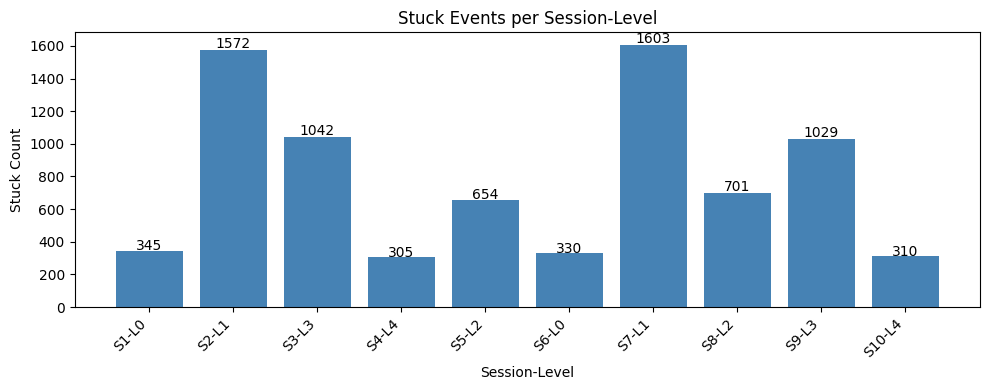

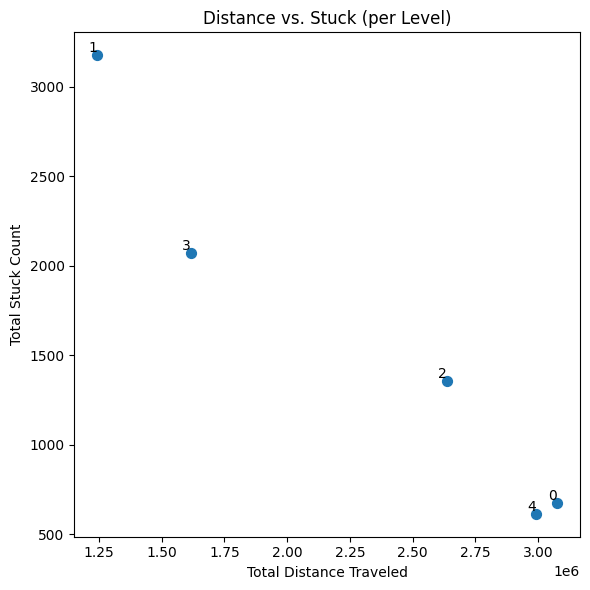

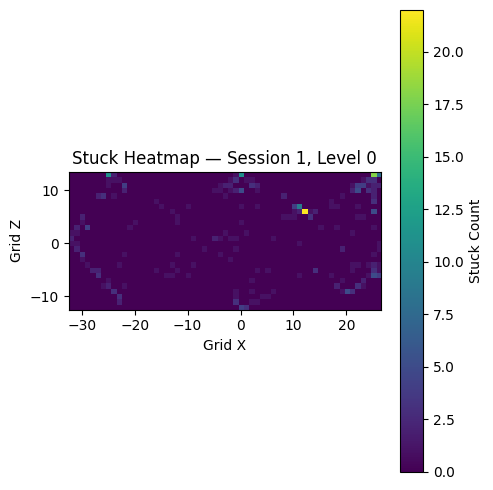

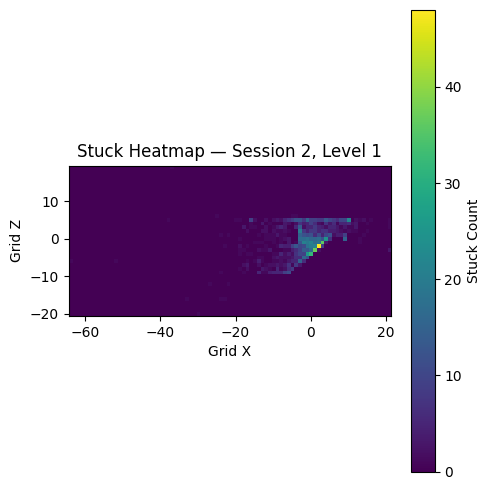

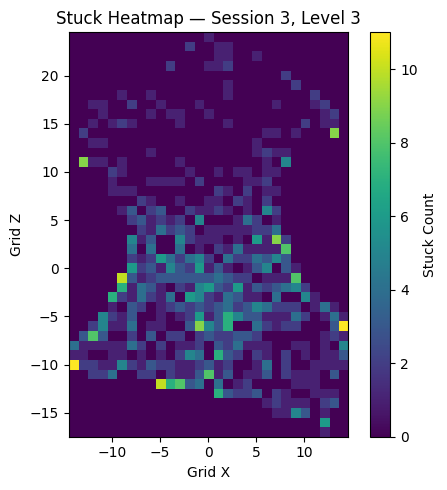

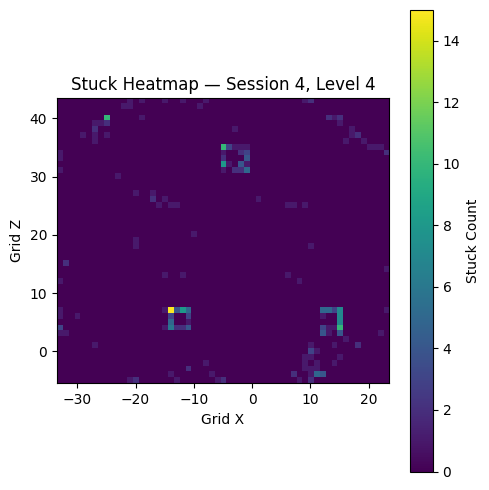

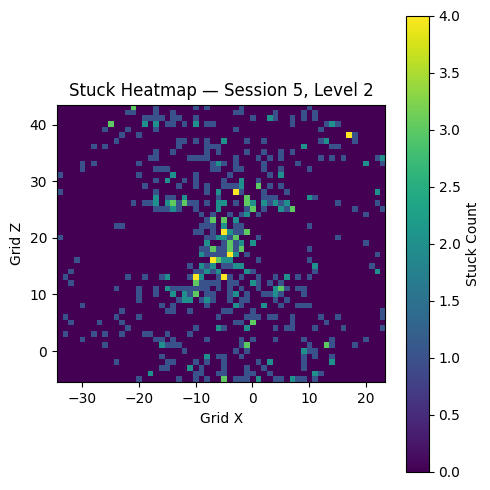

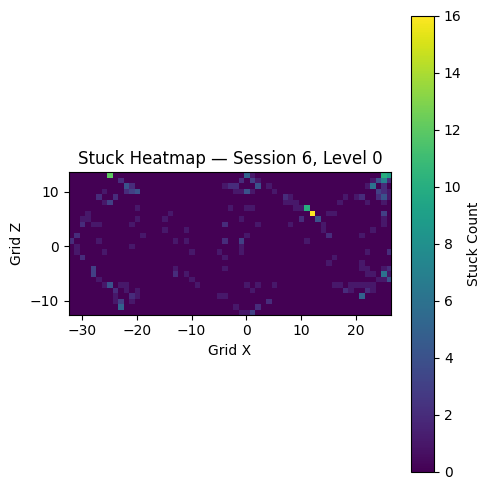

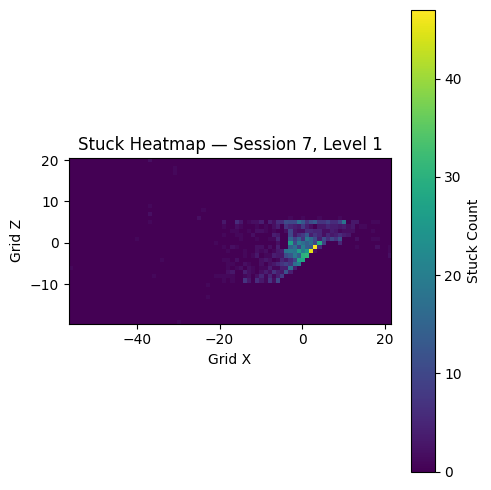

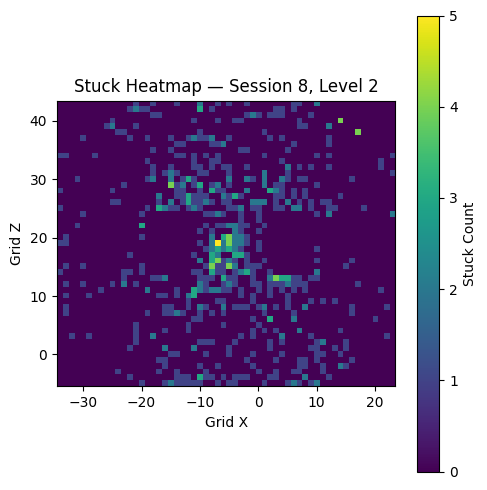

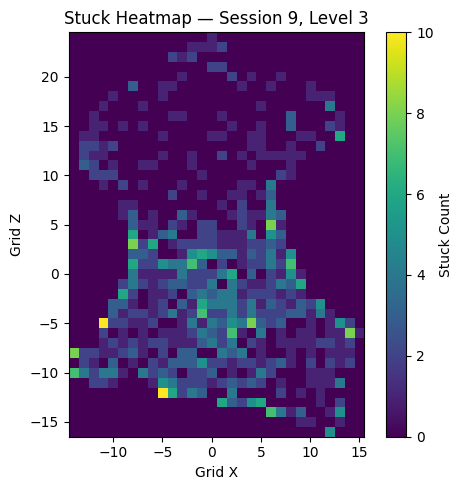

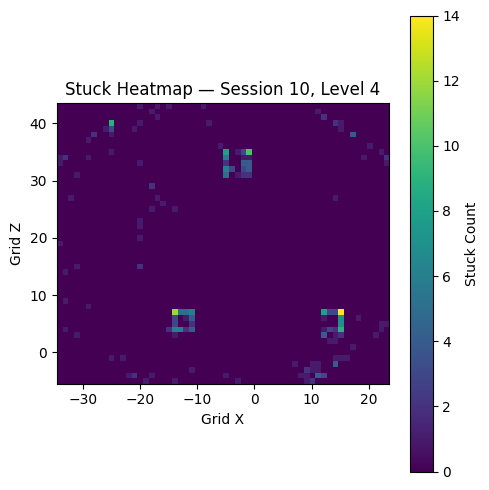

In [ ]:

#5.1 Atascos por Session-Level

# Las etiquetas de cada barra modelo -> "S1-L0" (más compensible)
metrics['label'] = metrics.apply(
    lambda r: f"S{r.session_idx}-L{r.level_idx}", axis=1
)

plt.figure(figsize=(10,4))
plt.bar(metrics['label'], metrics['stuck_count'], color='steelblue')
plt.xlabel('Session-Level')
plt.ylabel('Stuck Count')
plt.title('Stuck Events per Session-Level')
plt.xticks(rotation=45, ha='right')

# valires
for lbl, val in zip(metrics['label'], metrics['stuck_count']):
    plt.text(lbl, val+val*0.01, str(int(val)), ha='center')
plt.tight_layout()
plt.show()



# 5.2) Scatter distancia vs atascos por nivel

df_lvl = metrics.groupby('level_idx').agg({
    'distance_traveled':'sum',
    'stuck_count':'sum'
}).reset_index()

plt.figure(figsize=(6,6))
plt.scatter(df_lvl['distance_traveled'], df_lvl['stuck_count'], s=50)
plt.xlabel('Total Distance Traveled')
plt.ylabel('Total Stuck Count')
plt.title('Distance vs. Stuck (per Level)')

# Anotación con nivel
for _, row in df_lvl.iterrows():
    plt.text(row['distance_traveled'], row['stuck_count'], 
             str(int(row['level_idx'])), 
             ha='right', va='bottom')
plt.tight_layout()
plt.show()





#5.3 Mapas de calor (en gráficos)

import matplotlib.pyplot as plt
import numpy as np

# Heatmaps ajustados al rango de datos
for sess, lvl in metrics[['session_idx','level_idx']].values:
    df_f = df_pos[
        (df_pos.session_idx==sess) &
        (df_pos.level_idx  ==lvl) &
        (df_pos.isStuck)
    ]
    if df_f.empty: 
        continue

    # Conteo de atascos por casilla
    grid = df_f.groupby(['grid_x','grid_z']).size().reset_index(name='count')
    xs, zs, cs = grid['grid_x'], grid['grid_z'], grid['count']

    xmin, xmax = xs.min(), xs.max()
    zmin, zmax = zs.min(), zs.max()

    # Montar matriz ajustada
    mat = np.zeros((zmax-zmin+1, xmax-xmin+1))
    for x, z, c in zip(xs, zs, cs):
        mat[z-zmin, x-xmin] = c

    # Dibujo
    fig, ax = plt.subplots(figsize=(5,5))
    extent = [xmin-0.5, xmax+0.5, zmin-0.5, zmax+0.5]
    im = ax.imshow(
        mat,
        origin='lower',
        interpolation='nearest',
        extent=extent,
    )

    # Fijar ejes justo al rango de datos
    ax.set_xlim(xmin-0.5, xmax+0.5)
    ax.set_ylim(zmin-0.5, zmax+0.5)
    ax.set_aspect('equal')

    # Colores de gradiente y etiquetas
    plt.colorbar(im, label='Stuck Count', ax=ax)
    ax.set_title(f"Stuck Heatmap — Session {sess}, Level {lvl}")
    ax.set_xlabel('Grid X')
    ax.set_ylabel('Grid Z')
    plt.tight_layout()
    plt.show()



## 6. Conclusiones derivadas de las métricas

Con los datos que disponemos hasta la fecha, hemos llegado a las siguientes conclusiones:

De caracter general:

- Puede considerarse que la cantidad de atascos por posiciones medidas a lo largo de los niveles por todo el elenco de bots es muy aceptable, obteniendo datos inferiores en todos ellos al 0.1%.
- La superficie recorrida por los bot abarca la totalidad de cada uno de los mapas puesto que en los mapas de calor puede reconocerse el contorno de cada uno de los niveles y parte de los obstaculos de los mismos.
- La distancia recorrida por un bot afecta inversamente a la cantidad de atascos que le afectan, de tal manera que mapas con mayor cantidad de obtáculos o tamaño reducido concentran más atascos.
- La concentración de atascos en puntos concretos, como muestran los mapas de calor son facilmente solventables con ajustes de posiciones tanto de elementos del mapa como de puntos de spawn del jugador, pero tal vez sin estos datos no hubieramos sido capaces de 
        determinar fácilmente donde se encontraban.
- Tanto el comportamiento como el diseño de los bots ha sido acertado al arrojar datos veraces, útiles y verificables durante las pruebas realizadas y los valores obtenidos.

De caracter particular:

- Puede obsevarse que en niveles con dos alturas los bots tienen dificultades para acceder a las mismas y mapearlos.
- En el nivel 1, el spawn point del jugador y por ende de los clones, se hace tal vez en el lugar menos acertado porque estás rodeado de obstáculos y una zona con un amplio volumen de atascos.
- Los dos niveles diseñados a posteriori (3 y 4) ponen de manifiesto que un espacio reducido es más propenso concentrar más puntos de atasco, o que los bots tengan más posibilidades de encontrarlos por ello, mientras que los que son más amplios o tienen varias alturas dan tiempo a los bots para ver si son facilmente navegables y menos propensos a ser objetos de atascos.